In [116]:
#import librarys for sagemaker
import os
import boto3
import io
import seaborn as sns
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
%matplotlib inline
from sklearn.model_selection import train_test_split
from sagemaker.predictor import csv_serializer, json_deserializer
from __future__ import division

In [2]:
# import data sciences and vizualizations librarys
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

In [3]:
#list and load documents in bucket
s3_client = boto3.client('s3')
data_bucket_name = 'pedroagronanalytics'
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file =[]

In [151]:
# set data
copy = 'multiclass_decision_complete.v2.csv'
response = s3_client.get_object(Bucket=data_bucket_name, Key= copy)
response_body = response["Body"].read()
co = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", dtype=np.float32, low_memory=False)

In [153]:
type(co['Recomendação'][0])

numpy.float32

In [154]:
co['Recomendação']=co['Recomendação'].astype(int)

In [172]:
Variables_model = list(co.columns[:17])
Variables_model

['Capacidade_de_infiltração',
 'Prob_2',
 'Previsão_dia_2',
 'Prob_1',
 'Previsão_dia_1',
 'Chuva_dia_anterior',
 'activity_name',
 'altitude',
 'altitude_antec1',
 'altitude_antec2',
 'altutude_antec3',
 'altitude_antec4',
 'altitude_antec5',
 'altitude_antec6',
 'altitude_antec7',
 'altitude_antec8',
 'altitude_antec9']

In [168]:
covtype = co.values
covtype_features, covtype_labels = np.float32(covtype[:, :17]), np.float32(covtype[:, 17])
 # shuffle and split into train and test sets
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(
    covtype_features, covtype_labels, test_size=0.2)
 # further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)
covtype.shape
print(covtype_labels)

[2. 0. 2. 2. 0. 2. 2. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 2. 2. 0. 2.
 2. 0. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 0. 2. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3.]


In [163]:
covtype

array([[  0.        ,  60.        ,   2.        , ..., 570.90002441,
        570.20001221,   2.        ],
       [  0.        ,  60.        ,   2.        , ..., 570.70001221,
        570.90002441,   0.        ],
       [  0.        ,  60.        ,   2.        , ..., 571.90002441,
        570.70001221,   2.        ],
       ...,
       [  1.        ,  57.        ,   0.        , ..., 552.79998779,
        552.5       ,   3.        ],
       [  1.        ,  57.        ,   0.        , ..., 552.29998779,
        552.79998779,   3.        ],
       [  1.        ,  57.        ,   0.        , ..., 550.5       ,
        552.29998779,   3.        ]])

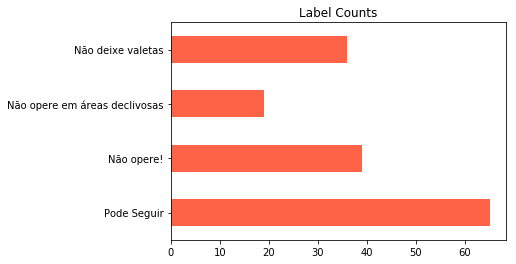

In [107]:
# assign label names and count label frequencies
label_map = {0:'Pode Seguir', 1:'Não deixe valetas', 2:'Não opere em áreas declivosas', 3:'Não opere!'}
label_counts = pd.DataFrame(data=train_labels)[0].map(label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot('barh', color='tomato', title='Label Counts')

In [169]:
#training classifier
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
multiclass_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='multiclass_classifier',
                                               num_classes=4)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-878439880672


In [170]:
# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(train_features, train_labels, channel='train')
val_records = multiclass_estimator.record_set(val_features, val_labels, channel='validation')
test_records = multiclass_estimator.record_set(test_features, test_labels, channel='test')

In [171]:
# start a training job
multiclass_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker:Creating training-job with name: linear-learner-2019-01-02-18-52-21-468


2019-01-02 18:52:21 Starting - Starting the training job...
2019-01-02 18:52:22 Starting - Launching requested ML instances......
2019-01-02 18:53:26 Starting - Preparing the instances for training......
2019-01-02 18:54:31 Downloading - Downloading input data
2019-01-02 18:54:31 Training - Downloading the training image...
2019-01-02 18:55:18 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[01/02/2019 18:55:20 INFO 139989123147584] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', 


2019-01-02 18:55:31 Uploading - Uploading generated training model
2019-01-02 18:55:31 Completed - Training job completed
Billable seconds: 69


In [173]:
# deploy a model hosting endpoint
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2019-01-02-19-06-19-183
INFO:sagemaker:Creating endpoint with name linear-learner-2019-01-02-18-52-21-468


---------------------------------------------------------------------------!

In [174]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 15 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 15)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.950


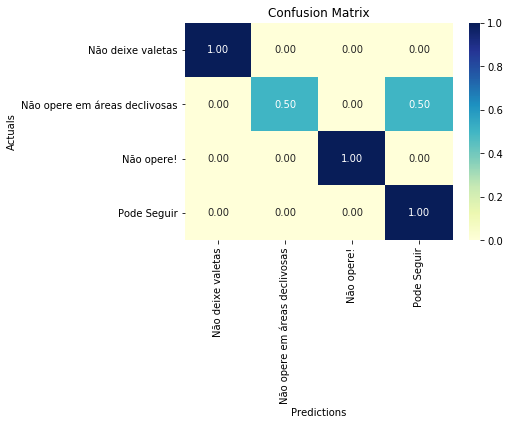

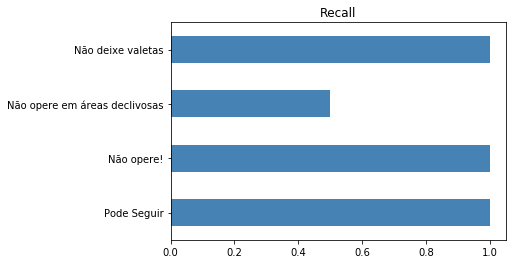

In [175]:
# evaluate metrics of the model trained with default hyperparameters
evaluate_metrics(multiclass_predictor, test_features, test_labels)